In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from nn.nn import NeuralNetwork 
from nn.io import read_text_file, read_fasta_file
from nn.preprocess import sample_seqs, one_hot_encode_seqs

## Loading Dataset and Trimming to Length

In [2]:
positive_seqs = read_text_file("data/rap1-lieb-positives.txt")
negative_seqs_raw = read_fasta_file("data/yeast-upstream-1k-negative.fa")

In [ ]:
seq_length = len(positive_seqs[0])

#little function to get a random sample of subsequene throughout each instance of negative sequence
#the model performs equally well if the negative string is randombly selected from the sequence or if its just clipped to the first 17 characters

def extract_random_subseq(seq, length):
    """Extracts a random substring of given length from the sequence."""
    start_idx = random.randint(0, len(seq) - length)  # Random start position
    return seq[start_idx : start_idx + length]  # Extract substring

# Apply to all negative sequences
negative_seqs = [extract_random_subseq(seq, seq_length) for seq in negative_seqs_raw]

## Sampling with replacement and One Hot Encoding DNA Sequences

In [4]:
#combining and labelling data
sequences = positive_seqs + negative_seqs
labels = [1] * len(positive_seqs) + [0] * len(negative_seqs)  #1 = positive, 0 = negative

#callig sample_seqs
balanced_seqs, balanced_labels = sample_seqs(sequences, labels)

In [5]:
#quick sanity check
print(f'{labels.count(0)} negative sequences before sampling with replacement')
print(f'{labels.count(1)} positive sequences before sampling with replacement')

print(f'{balanced_labels.count(0)} negative sequences after sampling with replacement')
print(f'{balanced_labels.count(1)} positive sequences after sampling with replacement')

3163 negative sequences before sampling with replacement
137 positive sequences before sampling with replacement
137 negative sequences after sampling with replacement
137 positive sequences after sampling with replacement


In [6]:
X = one_hot_encode_seqs(balanced_seqs)  #shape = (num_samples, seq_length * 4)
y = np.array(balanced_labels).reshape(-1, 1)  #convert labels into a column vector

In [7]:
#splitting into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Making instance of Neural Network Class

In [8]:
input_dim = X_train.shape[1]  # Number of features after encoding

classifier_arch = [
    {"input_dim": input_dim, "output_dim": 32, "activation": "relu"},
    {"input_dim": 32, "output_dim": 16, "activation": "relu"},
    {"input_dim": 16, "output_dim": 1, "activation": "sigmoid"}  #sigmoid for binary classification
]

In [ ]:
'''I picked these hyperparameters becuase any further minimizxation of the loss function despite a more convincing convergeange didn't have
any improvement of the models prediction accuracy, so I figured i'd err on the side of less overfitting. '''



classifier = NeuralNetwork(
    nn_arch=classifier_arch,
    lr=0.1,  # Adjust if needed
    seed=42,
    batch_size=32,
    epochs=500,
    loss_function="binary_cross_entropy" 
)

train_loss, val_loss = classifier.fit(X_train, y_train, X_val, y_val)


Sigmoid Output: Min: 0.48731220381677187, Max: 0.5153507099245451
Applying Sigmoid in layer with shape (1, 219)
BCE Gradients: Min -0.5046431524995628, Max 0.5153507099245451
Sigmoid Output: Min: 0.48731220381677187, Max: 0.5153507099245451
Layer 1: Max Weight Gradient: 0.0016895845557351678
Layer 1: Max Bias Gradient: 0.0010098614345495566
Layer 2: Max Weight Gradient: 0.0032656068380778423
Layer 2: Max Bias Gradient: 0.002101804525492972
Layer 3: Max Weight Gradient: 0.004985970235907477
Layer 3: Max Bias Gradient: 0.003774427053242574
Sigmoid Output: Min: 0.493626837900613, Max: 0.5107970703290969
Applying Sigmoid in layer with shape (1, 55)
Epoch 1 / 500: Train Loss = 0.6913, Val Loss = 0.6916
Sigmoid Output: Min: 0.4870528815824368, Max: 0.5152167887504551
Applying Sigmoid in layer with shape (1, 219)
BCE Gradients: Min -0.5047352654543549, Max 0.5152167887504551
Sigmoid Output: Min: 0.4870528815824368, Max: 0.5152167887504551
Layer 1: Max Weight Gradient: 0.0016818123243623594
La

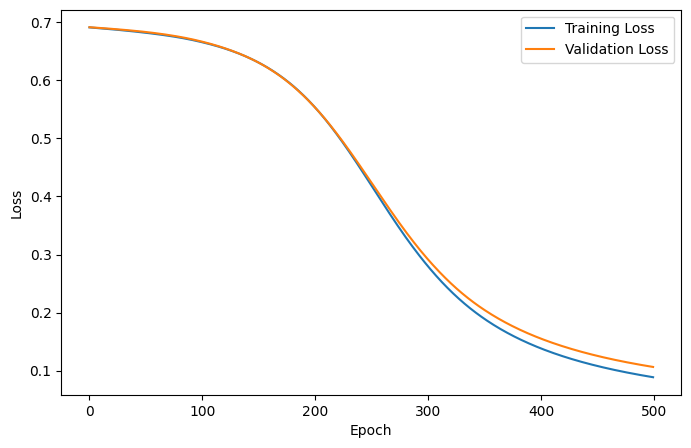

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Actually Check to see how we did

In [11]:
# Get predictions for validation set
y_pred_val = classifier.predict(X_val)

# Convert to binary values (if not already)
y_pred_val = y_pred_val.flatten()
y_true_val = y_val.flatten()

# Compute accuracy
accuracy = np.mean(y_pred_val == y_true_val)

# Print accuracy
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


Sigmoid Output: Min: 0.022361275287885396, Max: 0.9724067239738011
Applying Sigmoid in layer with shape (1, 55)
Validation Accuracy: 98.18%
